In [1]:
import warnings
warnings.filterwarnings("ignore")

import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
plt.rc('pdf', fonttype=42) # Avoid type 3 fonts

sns.set_theme(style="white")
sns.set_palette(sns.color_palette("tab10"))
plt.rcParams.update({"xtick.bottom" : True}) # enables ticks

In [2]:
#
# Android data
#

ANDROID_BASE_DIR = '../android'
ANDROID_RESULTS_DIR = os.path.join(ANDROID_BASE_DIR, '../results/small-hw-support-2024-05-25-125045/')

ANDROID_TESTS = {
    "small": "testBenchLongSloth_withOwasp_small",
    "large": "testBenchLongSloth_withOwasp_large",
}


def android_read_device_info(path):
    with open(path) as f:
        x = json.load(f)
        
    name = x['name'].replace('"', '')
    name = name.replace(' 5G', '')
        
    os = x['os']
    if '.' in os:
        os = os[:os.find('.')]
    
    return {
        'name': name,
        'os': int(os),
    }


def android_read_sloth_bench_results(dir_path, test_name):
    allL, allDurations = [], []
    
    with open(os.path.join(dir_path, f'{test_name}.json')) as f:
        x = json.load(f)
        
        for m in x:
            d = m['data']
            if m['tag'] != 'LogTracer' or test_name not in d:
                continue
            _, _, l, _, _, afterPwHashNs, _, finishNs = d.split(' ')
    
            allL.append(int(l.split('=')[1]))
        
            afterPwHashNs = int(afterPwHashNs.split('=')[1])
            finishNs = int(finishNs.split('=')[1])
            allDurations.append((finishNs - afterPwHashNs) / 1_000_000) # NS to MS
    
    return {
        'l': allL,
        'duration': allDurations, 
    }


def android_read_job_result(job_name, job_path, test_id, test_name):
    device_info = android_read_device_info(os.path.join(job_path, "device.json"))
    bench_results = android_read_sloth_bench_results(job_path, test_name)
    
    return {**device_info, **{'test': test_id}, **bench_results}

                  
def android_read_all_jobs():
    all_data = []
    for job_name in sorted(os.listdir(ANDROID_RESULTS_DIR)):
        job_path = os.path.join(ANDROID_RESULTS_DIR, job_name)
        
        if not os.path.isdir(job_path):
            continue
            
        for test_id, test_name in ANDROID_TESTS.items():
            x = android_read_job_result(job_name, job_path, test_id, test_name)
            if len(x['l']) < 10: continue
            all_data.append(x)
    return pd.json_normalize(all_data)
        
android_df = android_read_all_jobs()
android_df = android_df.explode(['l', 'duration'], ignore_index=True)
android_df = android_df.astype({'duration': 'float64'})

android_df.sample(20)

,name,os,test,l,duration
65,Samsung Galaxy S22,13,small,3072,90.076718
58,Samsung Galaxy S21,12,large,178176,579.408594
54,Samsung Galaxy S21,12,large,178176,609.394426
30,Google Pixel 7,13,large,24576,640.590414
52,Samsung Galaxy S21,12,large,178176,618.790261
68,Samsung Galaxy S22,13,small,3072,85.821250
74,Samsung Galaxy S22,13,large,145408,697.703645
33,Google Pixel 7,13,large,24576,663.435873
48,Samsung Galaxy S21,12,small,11264,92.668854
7,Google Pixel 3,10,small,2048,174.919653


In [3]:
#
# iOS data
#

IOS_BASE_DIR = '../ios'
IOS_DATA_DIR = os.path.join(IOS_BASE_DIR, '../results/ios-2023-03-19')

IOS_FILES = [
    '2023-03-19-090754_sloth_iPhone12-1_16-3.json',
    '2023-03-19-090838_sloth_iPhone12-1_16-3.json',
    '2023-03-19-091258_sloth_iPhone13-2_15-6-1.json',
    '2023-03-19-091329_sloth_iPhone13-2_15-6-1.json',
    '2023-03-19-092151_sloth_iPhone14-5_16-0-2.json',
    '2023-03-19-092217_sloth_iPhone14-5_16-0-2.json',
]


def ios_get_device_info(device_name):
    with open(os.path.join(IOS_BASE_DIR, 'models.json')) as f:
        return json.load(f)[device_name]


def ios_read_data(path):
    with open(path) as f:
        d = json.load(f)
        
    info = ios_get_device_info(d['device'])
    
    return pd.DataFrame(data={
        'Device': info['name'],
        'OS Version': d['version'],
        'Chip': info['chip'],
        'Configuration': f"{info['name']} ({d['version']})",
        'n': d['n'],
        'type': 'small' if d['n'] < 25 else 'large',
        'Measurement': [float(x) * 1000 for x in d['executionTimeSeconds']],
    })


def ios_read_all_data():
    for f in IOS_FILES:
        path = os.path.join(IOS_DATA_DIR, f)
        x = ios_read_data(path)
        yield x
        
ios_df = pd.concat(ios_read_all_data())
ios_df.sample(10)

,Device,OS Version,Chip,Configuration,n,type,Measurement
67,iPhone 13,16.0.2,A15,iPhone 13 (16.0.2),12,small,108.833075
57,iPhone 12,15.6.1,A14,iPhone 12 (15.6.1),76,large,772.531033
36,iPhone 12,15.6.1,A14,iPhone 12 (15.6.1),10,small,99.416018
37,iPhone 13,16.0.2,A15,iPhone 13 (16.0.2),95,large,745.931983
79,iPhone 13,16.0.2,A15,iPhone 13 (16.0.2),12,small,113.770008
82,iPhone 12,15.6.1,A14,iPhone 12 (15.6.1),76,large,737.080097
27,iPhone 13,16.0.2,A15,iPhone 13 (16.0.2),12,small,109.261990
85,iPhone 12,15.6.1,A14,iPhone 12 (15.6.1),10,small,105.733037
18,iPhone 13,16.0.2,A15,iPhone 13 (16.0.2),95,large,547.618985
16,iPhone 12,15.6.1,A14,iPhone 12 (15.6.1),10,small,102.077961


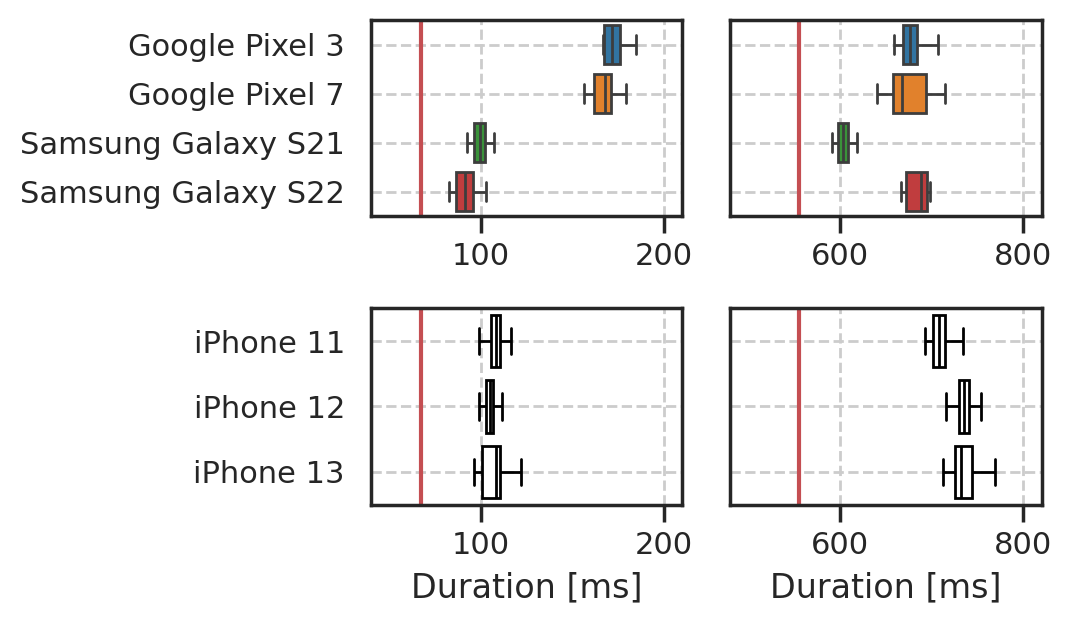

In [4]:
#
# Box plot with the Android LongSloth execution times
#

fig, axs = plt.subplots(2,2)
fig.set_size_inches((5.5, 3.3))

((ax1, ax2), (ax3, ax4)) = axs

#
# Android
#

sns.boxplot(
    data=android_df[android_df.test=='small'],
    y='name',
    x='duration',
    hue='name',
    ax=ax1,
    showfliers = False,
    dodge=False,
)
ax1.axvline(x=67, color='r')
ax1.set_xlabel(None)
ax1.set_ylabel(None)
ax1.grid(ls='--')
ax1.legend().remove()


sns.boxplot(
    data=android_df[android_df.test=='large'],
    y='name',
    x='duration',
    hue='name',
    ax=ax2,
    showfliers = False,
    dodge=False,
)
ax2.axvline(x=555, color='r')
ax2.set_xlabel(None)
ax2.set_yticklabels([])
ax2.set_ylabel(None)
ax2.grid(ls='--')
ax2.legend().remove()

#
# iOS
#

sns.boxplot(
    data=ios_df[ios_df.type=='small'],
    y='Device',
    x='Measurement',
    color='white',
    ax=ax3,
    showfliers = False,
    boxprops = {'edgecolor': 'black'},
    medianprops = {'color': 'black'},
    whiskerprops = {'color': 'black'},
    capprops = {'color': 'black'},
)
ax3.axvline(x=67, color='r')
ax3.set_xlabel("Duration [ms]")
ax3.set_ylabel(None)
ax3.grid(ls='--')


sns.boxplot(
    data=ios_df[ios_df.type=='large'],
    y='Device',
    x='Measurement',
    color='white',
    ax=ax4,
    showfliers = False,
    boxprops = {'edgecolor': 'black'},
    medianprops = {'color': 'black'},
    whiskerprops = {'color': 'black'},
    capprops = {'color': 'black'},
)
ax4.axvline(x=555, color='r')
ax4.set_xlabel("Duration [ms]")
ax4.set_yticklabels([])
ax4.set_ylabel(None)
ax4.grid(ls='--')


#
# Common
#

ax1.set_xlim((40, 210))
ax3.set_xlim((40, 210))
ax2.set_xlim((480, 820))
ax4.set_xlim((480, 820))

fig.tight_layout()
fig.savefig("output/android-and-ios-sloth-perf.pdf", dpi=300, bbox_inches='tight')